In [1]:
from gurobipy import *
import numpy as np
import math
from sklearn.gaussian_process.kernels import RBF
from scipy.optimize import minimize
import time
import scipy

import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoLarsCV
import statistics
import time
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.utils.random import sample_without_replacement

t_1 = time.time()
#parameters
X_multiplier=7#multiplier of X in demand calculation
priceMultiplier=1#multiplier of price in kernel
Gamma=3
P_low=5#3
P_high=10

sigma=1#bandwidth of kernel
dim=1#dim of feature X

def policy_to_evaluate(x,p):
    return 0.9*p

def expected_demand(x_arr,p_arr):
    #d_arr=(x_arr*X_multiplier-p_arr+P_high)/(P_high-P_low+X_multiplier)
    d_arr=(5*x_arr+3*(P_high-p_arr)-10)/10
    d_arr=np.minimum(d_arr,1)
    d_arr=np.maximum(d_arr,0)
    return d_arr

def realized_demand(x_arr,p_arr,rndseed):
    np.random.seed(rndseed+52028)
    return np.random.binomial(1,expected_demand(x_arr,p_arr))
    
#generate training dataset
rndseed=1848#927
train_size=30
np.random.seed(rndseed+883)
X_train=np.random.uniform(0,1,train_size)

np.random.seed(rndseed+428)
X_train=np.random.uniform(0,0.2,train_size)
X_train[10:20]+=0.4
X_train[20:30]+=0.8

#np.random.seed(rndseed+5325)
#P_train=np.random.uniform(P_low,P_high,train_size)
P_train=P_high-(P_high-P_low)*X_train#deterministic pricing
D_train=realized_demand(X_train,P_train,rndseed+917)

#generate testing dataset
P_test=np.zeros(train_size)
for i in range(0,train_size):
    P_test[i]=policy_to_evaluate(X_train[i],P_train[i])

#pre-compute values needed
R_train=np.multiply(D_train,P_train)
expected_R_train=np.multiply(P_train,expected_demand(X_train,P_train))
expected_R_test=np.multiply(P_test,expected_demand(X_train,P_test))
expected_val_test=sum(expected_R_test)/train_size

#for computing kernel only: normalize prices, and multiply by given factor
P_train_norm=priceMultiplier*(P_train-P_low)/ (P_high-P_low)

Z_train=np.zeros((train_size,dim+1))
for i in range(0,train_size):
    Z_train[i]=np.append(X_train[i],P_train_norm[i])#historical policy
Y_train=np.zeros((train_size,dim+1))
for i in range(0,train_size):
    Y_train[i]=np.append(X_train[i],policy_to_evaluate(X_train[i],P_train_norm[i]))#new policy

#gram matrix
kernel = RBF(sigma)
Z_and_Y=np.zeros((train_size*2,dim+1))
Z_and_Y[0:train_size,:]=Z_train
Z_and_Y[train_size:2*train_size,:]=Y_train
G=kernel(Z_and_Y)
G=G+0.0001*np.identity(train_size*2)#make G positive semi-definite
C=np.linalg.cholesky(G*2)#C is lower triangular, CC^\top=G

#preparation
rowSumHalfG=np.transpose(np.sum(G[:,train_size:2*train_size],axis=1).reshape(-1,1))#sum each row of right half of G
D3=np.transpose(rowSumHalfG).dot(rowSumHalfG)/(train_size**2)#the third term in Dw
arr_m=np.zeros((train_size,train_size*2,train_size*2))
for i in range(0,train_size):
    temp2=G[:,i].reshape(-1,1)
    arr_m[i]=temp2.dot(np.transpose(temp2))

In [2]:
#Nathan's method
#input penalty parameter lambda. Output weights
def nathans_method(lamda): 
    G_aug=np.copy(G)
    for i in range(0,train_size):
        G_aug[i][i]=G_aug[i][i]+lamda**2#add variance term

    #evals and evectors of G
    evals,evecs=scipy.linalg.eigh(G_aug, eigvals_only=False)#this method assumes real symmetric matrix, and is fast
    A=np.diag(evals)
    c=np.sum(evecs[0:train_size,0:2*train_size],axis=0)

    #build optimization model
    m = Model()
    m.Params.LogToConsole = 0#suppress Gurobipy printing
    # Add variables
    v=m.addMVar ( train_size*2, ub=100.0,lb=-100.0,name="v" )
    # Set objective function
    #m.Params.OptimalityTol=0.01
    m.setObjective(v@A@v, GRB.MINIMIZE) 
    # Add constraints
    #m.addConstr(v@c==1)#now remove the simplex contraint
    m.addConstr(evecs[train_size:2*train_size,0:2*train_size]@v==-np.ones(train_size)/train_size)
    #m.addConstr(S[0:train_size,0:2*train_size]@v>=-np.zeros(train_size))#w_i>=0
    #m.params.method=0#0 is primal simplex, 1 is dual simplex, 2 is barrier
    m.update()
    m.optimize()

    #get weights
    v_star=np.zeros(2*train_size)
    for i in range(0,2*train_size):
        v_star[i]=v[i].x
    w=evecs[0:train_size,0:2*train_size]@v_star
    
    return w

In [3]:
#subroutine that computes phi(w) using binary search
#input: weights. output: phi(w) and gradient
def subroutine_binary_search(weights,Gamma):

    #compute D(w)
    wSumHalfG=(G[:,0:train_size].dot(weights)).reshape(-1,1)
    D2=2*wSumHalfG.dot(rowSumHalfG)/train_size#the second term in Dw
    D1=wSumHalfG.dot(np.transpose(wSumHalfG))#the first term in Dw
    for i in range(0,train_size):
        D1=D1-arr_m[i]*weights[i]**2
    Dw=-2*D1+D2+np.transpose(D2)-2*D3#Dw may not be PSD

    #compute S
    M=np.linalg.solve(C,Dw)#solve matrix M for CM=Dw
    B=np.linalg.solve(C,np.transpose(M))#solve matrix B for CB=M^\top

    evals,evecs=scipy.linalg.eigh(B, eigvals_only=False)#symmetric QR
    Q=np.copy(evecs)
    delta=np.copy(evals)
    S=np.linalg.solve(np.transpose(C),Q)
    
    #compute bw, epsilon
    temp2=np.multiply(np.multiply(weights,weights),P_train)
    bw=-G[:,0:train_size]@temp2
    epsilon=np.transpose(S).dot(bw)
    
    #binary search algorithm
    lambda_L=max(0,-min(delta))#ensure delta+lambda_L>=0
    lambda_U=100
    tol=0.000000001      
    while lambda_U-lambda_L>=tol:
        lambda_M=(lambda_U+lambda_L)/2
        x_star=np.divide(-epsilon,delta+lambda_M)
        if np.linalg.norm(x_star)>Gamma*(2**0.5):
            lambda_L=lambda_M
        else:
            lambda_U=lambda_M 
    optimal_dual=lambda_U
    x_star=np.divide(-epsilon,delta+optimal_dual) #recover opti primal variable from opti dual variable
    
    #get key values
    obj = np.multiply(delta,x_star)@x_star/2+epsilon@x_star
    obj_val = -obj #return phi(w) 
    q=S@x_star#worst case r()
    
    #compute gradient
    grad=np.zeros(train_size)
    for i in range(0,train_size):
        temp1=np.transpose(G[:,i]).reshape(-1,1)
        temp2=np.transpose(wSumHalfG)-weights[i]*np.transpose(temp1)-rowSumHalfG/train_size
        Hessian=2*temp1.dot(temp2)
        grad[i]=q.dot(Hessian.dot(np.transpose(q)))
        grad[i]=grad[i]+2*weights[i]*P_train[i]*np.transpose(G[:,i]).dot(q)
    
    return obj_val,grad

In [4]:
#compute gradients using finite central diffs
#input weights and objective value at this set of weights
def finite_centra_diff(weights,obj_1,Gamma):
    finite_central_grad=np.zeros(train_size)
    h=0.0001
    for i in range(0,train_size):    
        w_temp=np.copy(weights)
        w_temp[i]=w_temp[i]+h
        obj_2,_=subroutine_binary_search(w_temp,Gamma)

        finite_central_grad[i]=(obj_2-obj_1)/(h)
    return finite_central_grad

In [5]:
#main loop. Frank-Wolfe algorithm 
#compute weights that minimize MSE(w) 
def PGD(w,Gamma):

    #main loop. Frank-Wolfe algorithm. Now use binary search
    obj_val_old,grad=subroutine_binary_search(w,Gamma) 
    #print('initial objective value: ',obj_val_old) 
    #if Gamma>3:
    #    grad=finite_centra_diff(w,obj_val_old,Gamma)

    k=1 
    L=max(10,Gamma*100)#a guess on lipschitz constant of phi(w) 
    maxIter=500
    MSE_arr=np.zeros(maxIter+1) 
    MSE_arr[0]=obj_val_old 
    stepSize_arr=np.zeros(maxIter+1) 
    step_size=1
    gt=1
    eta=0.1#parameter in Armijo rule
    tau=0.8#parameter in Armijo rule
    counter_small_steps=0
    while (k<=maxIter and counter_small_steps<20):

        #compute descent direction
        #if Gamma>3:#when Gamma>3, Danskin's Theorem no longer apply
        #    grad=finite_centra_diff(w,obj_val_old,Gamma)
        
        #initial step size
        descent_dir=-grad
        gt=-grad@descent_dir
        step_size=1/L
        #step_size=min(gt/(L*descent_dir@descent_dir),1)

        #project
        w_toProject=w-step_size*grad
        w_projected=np.maximum(w_toProject,np.zeros(train_size))
        obj_val_new,grad=subroutine_binary_search(w_projected,Gamma)

        #Backtracking. Use Armijo rule for step size
        counter_Armijo=0
        while obj_val_old-obj_val_new<step_size*gt*eta and counter_Armijo<20:
            counter_Armijo+=1
            step_size=step_size*tau
            w_toProject=w-step_size*grad
            w_projected=np.maximum(w_toProject,np.zeros(train_size))
            obj_val_new,grad=subroutine_binary_search(w_projected,Gamma)
        
            if counter_Armijo==20:
                counter_small_steps+=1

        obj_val_old=obj_val_new
        #store key outputs
        MSE_arr[k]=obj_val_new
        stepSize_arr[k]=step_size

        #update weights
        w=w+step_size*descent_dir
        #if (k % 100==0):
            #print('iter: ',k,'obj val: ',obj_val_new,'gt: ',gt,'min grad: ',min(grad),'coord: ',ind)
        k=k+1
        #if counter_small_steps==20:
            #print('Gamma= ',Gamma, 'terminated before maxIter')

    #truncate dummy values
    total_iter=k
    MSE_arr=MSE_arr[0:k]
    stepSize_arr=stepSize_arr[0:k]
    
    return w,MSE_arr

In [6]:
#compute true MSE, use our formula for MSE
def true_MSE(w):
    bias=w@expected_R_train-expected_val_test
    #temp1=np.multiply(R_train,P_train-R_train)#this will be zeros since R_train is either P_train or zero
    temp1=np.multiply(expected_R_train,P_train-expected_R_train)
    temp2=np.multiply(w,w)
    variance=temp1@temp2
    #variance=expected_R_test@(P_test-expected_R_test)/(train_size**2)
    return bias**2,variance,bias**2+variance

In [7]:
#main loop
#test our method for oracle Gamma
w_0=nathans_method(1)#starting point for our weights
#Gamma_list=np.append(np.arange(1,6)*0.05,np.arange(1,11)*1)
Gamma_list=np.append(np.arange(1,11)*0.05,np.arange(1,11))
Gamma_list=np.append(Gamma_list,np.arange(6,11)*2)
true_MSE_ours=np.zeros(len(Gamma_list))
worst_MSE_ours=np.zeros(len(Gamma_list))
est_val_ours=np.zeros(len(Gamma_list))
var_ours=np.zeros(len(Gamma_list))
w_ours_all=np.zeros((len(Gamma_list),train_size))
w_ours=np.copy(w_0)
for l in range(0,len(Gamma_list)):
    Gamma=Gamma_list[l]
    w_ours,MSE_arr=PGD(w_ours,Gamma)#warm start at previous soln
    w_ours_all[l]=np.copy(w_ours)#store outputs
    _,var_ours[l],true_MSE_ours[l]=true_MSE(w_ours)
    worst_MSE_ours[l],_=subroutine_binary_search(w_ours,Gamma)
    #est_val_ours[l]=w_ours@R_train
    est_val_ours[l]=w_ours@expected_R_train
    print('Gamma= ',Gamma,' complete')
optimal_Gamma=Gamma_list[np.argmin(true_MSE_ours)]
print('optimal Gamma= ',optimal_Gamma)

Academic license - for non-commercial use only - expires 2022-09-08
Using license file C:\Users\yunfan\gurobi.lic
Gamma=  0.05  complete
Gamma=  0.1  complete
Gamma=  0.15000000000000002  complete
Gamma=  0.2  complete
Gamma=  0.25  complete
Gamma=  0.30000000000000004  complete
Gamma=  0.35000000000000003  complete
Gamma=  0.4  complete
Gamma=  0.45  complete
Gamma=  0.5  complete
Gamma=  1.0  complete
Gamma=  2.0  complete
Gamma=  3.0  complete
Gamma=  4.0  complete
Gamma=  5.0  complete
Gamma=  6.0  complete
Gamma=  7.0  complete
Gamma=  8.0  complete
Gamma=  9.0  complete
Gamma=  10.0  complete
Gamma=  12.0  complete
Gamma=  14.0  complete
Gamma=  16.0  complete
Gamma=  18.0  complete
Gamma=  20.0  complete
optimal Gamma=  3.0


In [8]:
#test nathan's method for oracle lambda
lamda_list=np.append(np.arange(1,100)*0.0005,np.arange(1,201)*0.05)
true_MSE_nathan=np.zeros(len(lamda_list))
worst_MSE_nathan=np.zeros(len(lamda_list))
est_val_nathan=np.zeros(len(lamda_list))
var_nathan=np.zeros(len(lamda_list))
w_nathan_all=np.zeros((len(lamda_list),train_size))
for l in range(0,len(lamda_list)):
    lamda=lamda_list[l]
    w_nathan=nathans_method(lamda)
    w_nathan_all[l]=w_nathan
    _,var_nathan[l],true_MSE_nathan[l]=true_MSE(w_nathan)
    worst_MSE_nathan[l],_=subroutine_binary_search(w_nathan,3)
    #est_val_nathan[l]=w_nathan@R_train
    est_val_nathan[l]=w_nathan@expected_R_train
    #if l%10==0:
        #print('lambda= ',lamda,' complete')
optimal_lambda=lamda_list[np.argmin(true_MSE_nathan)]
print('optimal lambda= ',optimal_lambda)

t_2 = time.time()
print('run time: ',t_2-t_1)

optimal lambda=  0.0005
run time:  95.62122225761414


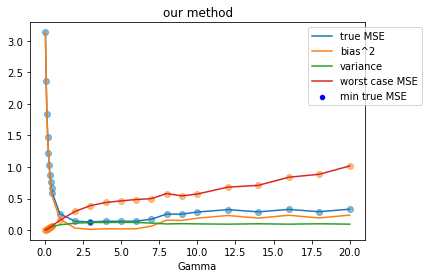

In [9]:
#plot our MSE against gamma
from matplotlib import pyplot
pyplot.plot(Gamma_list, true_MSE_ours,label='true MSE')
pyplot.plot(Gamma_list, np.subtract(true_MSE_ours,var_ours),label='bias^2')
pyplot.plot(Gamma_list, var_ours,label='variance')

pyplot.plot(Gamma_list, worst_MSE_ours,label='worst case MSE')
plt.scatter(Gamma_list[np.argmin(true_MSE_ours)],min(true_MSE_ours),s=20,color="blue",label='min true MSE')

plt.scatter(Gamma_list, true_MSE_ours,alpha=0.5)
plt.scatter(Gamma_list, worst_MSE_ours,alpha=0.5)
#plt.axvline(x=approx_rkhs_norm, color='g', linestyle=':', linewidth=3
#           ,label='true RKHS norm of r')#vertical line at true RKHS norm of rev fun
pyplot.title('our method')
pyplot.xlabel('Gamma')
pyplot.ylabel('')
pyplot.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center')
pyplot.show()

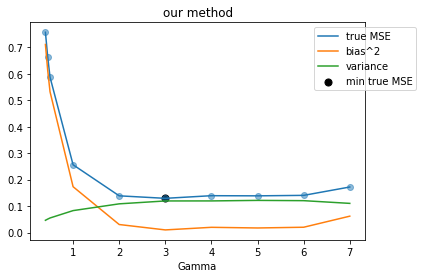

In [11]:
#zoom in on opt param for our method
from matplotlib import pyplot
ours_opt_index=np.argmin(true_MSE_ours)
lower_index=max(0,ours_opt_index-5)
upper_index=min(ours_opt_index+5,len(Gamma_list))
pyplot.plot(Gamma_list[lower_index:upper_index], true_MSE_ours[lower_index:upper_index],label='true MSE')
pyplot.plot(Gamma_list[lower_index:upper_index], np.subtract(true_MSE_ours,var_ours)[lower_index:upper_index],label='bias^2')
pyplot.plot(Gamma_list[lower_index:upper_index], var_ours[lower_index:upper_index],label='variance')

plt.scatter(Gamma_list[np.argmin(true_MSE_ours)],min(true_MSE_ours),s=50,color="black",label='min true MSE')
plt.scatter(Gamma_list[lower_index:upper_index], true_MSE_ours[lower_index:upper_index],alpha=0.5)
pyplot.title('our method')
pyplot.xlabel('Gamma')
pyplot.ylabel('')
pyplot.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center')
pyplot.show()

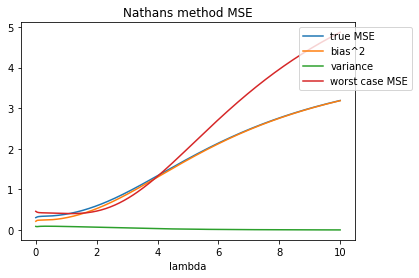

In [12]:
#plot nathans MSE against gamma
from matplotlib import pyplot
pyplot.plot(lamda_list, true_MSE_nathan,label='true MSE')
pyplot.plot(lamda_list, np.subtract(true_MSE_nathan,var_nathan),label='bias^2')
pyplot.plot(lamda_list, var_nathan,label='variance')

pyplot.plot(lamda_list, worst_MSE_nathan,label='worst case MSE')
#plt.scatter(lamda_list[np.argmin(true_MSE_nathan)],min(true_MSE_nathan),s=20,color="blue",label='min true MSE')
#plt.scatter(lamda_list, true_MSE_nathan,alpha=0.5)
#plt.scatter(lamda_list, worst_MSE_nathan,alpha=0.5)
pyplot.title('Nathans method MSE')
pyplot.xlabel('lambda')
pyplot.ylabel('')
pyplot.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center')
pyplot.show()

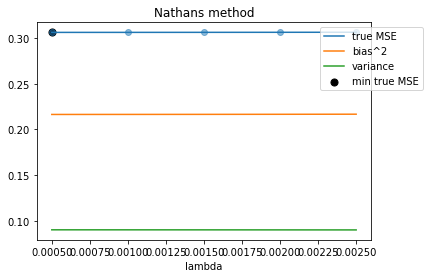

In [13]:
#zoom in on opt param for nathans method
from matplotlib import pyplot
nathan_opt_index=np.argmin(true_MSE_nathan)
lower_index=max(0,nathan_opt_index-5)
upper_index=min(nathan_opt_index+5,len(lamda_list))
pyplot.plot(lamda_list[lower_index:upper_index], true_MSE_nathan[lower_index:upper_index],label='true MSE')
pyplot.plot(lamda_list[lower_index:upper_index], np.subtract(true_MSE_nathan,var_nathan)[lower_index:upper_index],label='bias^2')
pyplot.plot(lamda_list[lower_index:upper_index], var_nathan[lower_index:upper_index],label='variance')

plt.scatter(lamda_list[np.argmin(true_MSE_nathan)],min(true_MSE_nathan),s=50,color="black",label='min true MSE')
plt.scatter(lamda_list[lower_index:upper_index], true_MSE_nathan[lower_index:upper_index],alpha=0.5)
pyplot.title('Nathans method')
pyplot.xlabel('lambda')
pyplot.ylabel('')
pyplot.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center')
pyplot.show()

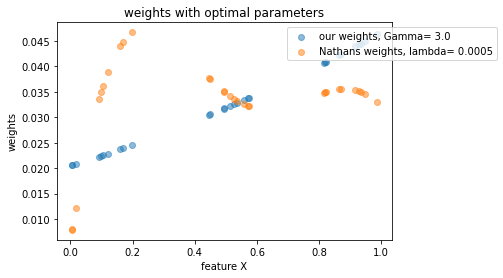

In [14]:
#plot weights with optimal parameters
from matplotlib import pyplot
plt.scatter(X_train, w_ours_all[np.argmin(true_MSE_ours)],alpha=0.5,label='our weights, Gamma= '+str(optimal_Gamma))
#plt.scatter(X_train, w_ours_all[1],alpha=0.5,label='our weights, Gamma= '+str(Gamma_list[1]))
plt.scatter(X_train, w_nathan_all[np.argmin(true_MSE_nathan)],alpha=0.5,label='Nathans weights, lambda= '+str(optimal_lambda))
pyplot.title('weights with optimal parameters')
pyplot.xlabel('feature X')
pyplot.ylabel('weights')
pyplot.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center')
pyplot.show()

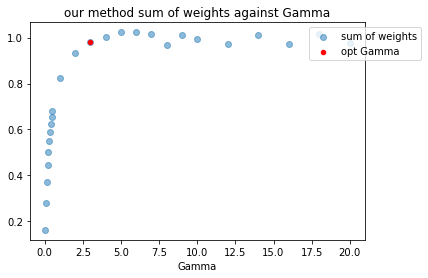

In [15]:
#plot sum of weights for each value of Gamma
from matplotlib import pyplot
sum_weights=np.sum(w_ours_all,axis=1)
plt.scatter(Gamma_list, sum_weights,alpha=0.5,label='sum of weights')
plt.scatter(Gamma_list[np.argmin(true_MSE_ours)],sum_weights[np.argmin(true_MSE_ours)],s=20,color="red",label='opt Gamma')

pyplot.title('our method sum of weights against Gamma')
pyplot.xlabel('Gamma')
pyplot.ylabel('')
pyplot.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center')
pyplot.show()

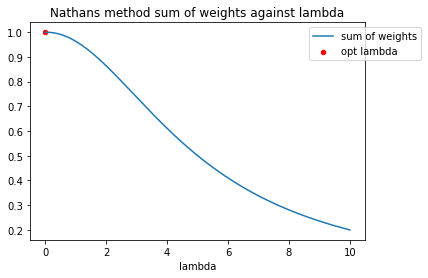

In [16]:
#plot sum of weights for each value of lambda
from matplotlib import pyplot
sum_weights=np.sum(w_nathan_all,axis=1)
#plt.scatter(lamda_list, sum_weights,alpha=0.5,label='sum of weights')
plt.plot(lamda_list, sum_weights,label='sum of weights')
plt.scatter(lamda_list[np.argmin(true_MSE_nathan)],sum_weights[np.argmin(true_MSE_nathan)],s=20,color="red",label='opt lambda')

pyplot.title('Nathans method sum of weights against lambda')
pyplot.xlabel('lambda')
pyplot.ylabel('')
pyplot.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center')
pyplot.show()

In [17]:
print('with optimal parameters')
print('our method MSE: ',min(true_MSE_ours))
print('Nathans method MSE: ',min(true_MSE_nathan))

with optimal parameters
our method MSE:  0.12931653448999175
Nathans method MSE:  0.30645202111511277


In [ ]:
#now repeat above for different training datasets
numTrial=10
optimal_Gamma_list=np.zeros(numTrial)
optimal_lambda_list=np.zeros(numTrial)
true_MSE_ours_optimal_Gamma=np.zeros(numTrial)
true_MSE_nathan_optimal_lambda=np.zeros(numTrial)

for j in range(0,numTrial):    
    #################################################################################################
    #generate training dataset
    rndseed=23497+j*439
    np.random.seed(rndseed+883)
    X_train=np.random.uniform(0,1,train_size)
    
    np.random.seed(rndseed+428)
    X_train=np.random.uniform(0,0.2,train_size)
    X_train[10:20]+=0.4
    X_train[20:30]+=0.8
    
    P_train=P_high-(P_high-P_low)*X_train#deterministic pricing
    D_train=realized_demand(X_train,P_train,rndseed+917)

    #generate testing dataset
    P_test=np.zeros(train_size)
    for i in range(0,train_size):
        P_test[i]=policy_to_evaluate(X_train[i],P_train[i])

    #pre-compute values needed
    R_train=np.multiply(D_train,P_train)
    expected_R_train=np.multiply(P_train,expected_demand(X_train,P_train))
    expected_R_test=np.multiply(P_test,expected_demand(X_train,P_test))
    expected_val_test=sum(expected_R_test)/train_size

    #for computing kernel only: normalize prices, and multiply by given factor
    P_train_norm=priceMultiplier*(P_train-P_low)/ (P_high-P_low)

    Z_train=np.zeros((train_size,dim+1))
    for i in range(0,train_size):
        Z_train[i]=np.append(X_train[i],P_train_norm[i])#historical policy
    Y_train=np.zeros((train_size,dim+1))
    for i in range(0,train_size):
        Y_train[i]=np.append(X_train[i],policy_to_evaluate(X_train[i],P_train_norm[i]))#new policy

    #gram matrix
    Z_and_Y=np.zeros((train_size*2,dim+1))
    Z_and_Y[0:train_size,:]=Z_train
    Z_and_Y[train_size:2*train_size,:]=Y_train
    G=kernel(Z_and_Y)
    G=G+0.0001*np.identity(train_size*2)#make G positive semi-definite
    C=np.linalg.cholesky(G*2)#C is lower triangular, CC^\top=G

    #preparation
    rowSumHalfG=np.transpose(np.sum(G[:,train_size:2*train_size],axis=1).reshape(-1,1))#sum each row of right half of G
    D3=np.transpose(rowSumHalfG).dot(rowSumHalfG)/(train_size**2)#the third term in Dw
    arr_m=np.zeros((train_size,train_size*2,train_size*2))
    for i in range(0,train_size):
        temp2=G[:,i].reshape(-1,1)
        arr_m[i]=temp2.dot(np.transpose(temp2))


    ###################################################################################################
    #main loop
    #test our method for oracle Gamma
    w_0=nathans_method(1)#starting point for our weights
    #Gamma_list=np.append(np.arange(1,6)*0.05,np.arange(1,11)*1)
    Gamma_list=np.append(np.arange(1,11)*0.05,np.arange(1,11))
    true_MSE_ours=np.zeros(len(Gamma_list))
    worst_MSE_ours=np.zeros(len(Gamma_list))
    est_val_ours=np.zeros(len(Gamma_list))
    w_ours_all=np.zeros((len(Gamma_list),train_size))
    w_ours=np.copy(w_0)
    for l in range(0,len(Gamma_list)):
        Gamma=Gamma_list[l]
        w_ours,MSE_arr=PGD(w_ours,Gamma)#warm start at previous soln
        w_ours_all[l]=np.copy(w_ours)#store outputs
        _,_,true_MSE_ours[l]=true_MSE(w_ours)
        worst_MSE_ours[l],_=subroutine_binary_search(w_ours,Gamma)
        est_val_ours[l]=w_ours@R_train
    optimal_Gamma=Gamma_list[np.argmin(true_MSE_ours)]
    print('optimal Gamma= ',optimal_Gamma)
    optimal_Gamma_list[j]=optimal_Gamma
    true_MSE_ours_optimal_Gamma[j]=min(true_MSE_ours)
    
    ########################################################################################################
    #test nathan's method for oracle lambda
    lamda_list=np.append(np.arange(1,100)*0.0005,np.arange(1,201)*0.05)
    true_MSE_nathan=np.zeros(len(lamda_list))
    worst_MSE_nathan=np.zeros(len(lamda_list))
    est_val_nathan=np.zeros(len(lamda_list))
    w_nathan_all=np.zeros((len(lamda_list),train_size))
    for l in range(0,len(lamda_list)):
        lamda=lamda_list[l]
        w_nathan=nathans_method(lamda)
        w_nathan_all[l]=w_nathan
        _,_,true_MSE_nathan[l]=true_MSE(w_nathan)
        worst_MSE_nathan[l],_=subroutine_binary_search(w_nathan,3)
        est_val_nathan[l]=w_nathan@R_train
    optimal_lambda=lamda_list[np.argmin(true_MSE_nathan)]
    print('optimal lambda= ',optimal_lambda)
    optimal_lambda_list[j]=optimal_lambda
    true_MSE_nathan_optimal_lambda[j]=min(true_MSE_nathan)

    
    
    t_3 = time.time()
    print('total run time: ',t_3-t_1)

optimal Gamma=  3.0


In [ ]:
#plot true MSE for both methods
from matplotlib import pyplot

plt.scatter(np.arange(numTrial), true_MSE_ours_optimal_Gamma,label='our method',alpha=0.5)
plt.scatter(np.arange(numTrial), true_MSE_nathan_optimal_lambda,label='Nathans method',alpha=0.5)

pyplot.title('true MSE')
pyplot.xlabel('# of trial')
pyplot.ylabel('')
pyplot.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center')
pyplot.show()

In [ ]:
#plot optimal parameters for both methods
from matplotlib import pyplot

plt.scatter(np.arange(numTrial), optimal_Gamma_list,label='our method opt Gamma',alpha=0.5)
plt.scatter(np.arange(numTrial), optimal_lambda_list,label='Nathans method opt lambda',alpha=0.5)

pyplot.title('optimal parameters')
pyplot.xlabel('# of trial')
pyplot.ylabel('')
pyplot.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center')
pyplot.show()